#### Import Modules


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### Main Definitions


In [2]:
# Define algorithms
algorithms = ['drl', 'least', 'random', 'round']

# Initialize results
summary = []

#### Loop over algorithms and print summary


In [3]:
for algo in algorithms:
    cloudlet_df = pd.read_csv(f"data/{algo}_cloudlets.csv")
    vms_df = pd.read_csv(f"data/{algo}_vms.csv")
    
    # Cloudlet stats
    total_cloudlet_cost = cloudlet_df['Cost $'].sum()
    mean_cloudlet_cost = cloudlet_df['Cost $'].mean()
    mean_completion_time = cloudlet_df['CompletionTime Seconds'].mean()
    total_cloudlets = cloudlet_df.shape[0]
    
    # VM stats
    total_vm_cost = vms_df['Cost $'].sum()
    mean_vm_cost = vms_df['Cost $'].mean()
    mean_cpu_util = vms_df['CPU Util %'].mean()
    total_vms = vms_df.shape[0]
    
    # Simulation time
    simulation_time = cloudlet_df['FinishTime Seconds'].max()
    
    # Store summary
    summary.append({
        'Algorithm': algo,
        'Total Cloudlet Cost ($)': total_cloudlet_cost,
        'Mean Cloudlet Cost ($)': mean_cloudlet_cost,
        'Mean Completion Time (s)': mean_completion_time,
        'Total VM Cost ($)': total_vm_cost,
        'Mean VM Cost ($)': mean_vm_cost,
        'Mean CPU Utilization (%)': mean_cpu_util,
        'Total Cloudlets': total_cloudlets,
        'Total VMs': total_vms,
        'Simulation Time (s)': simulation_time
    })

# Create summary DataFrame
summary_df = pd.DataFrame(summary)

print("\nSummary Statistics:\n", summary_df)

# Save to CSV
# summary_df.to_csv('summary_results.csv', index=False)


Summary Statistics:
   Algorithm  Total Cloudlet Cost ($)  Mean Cloudlet Cost ($)  \
0       drl                 70277.06              566.750484   
1     least                140322.54             1031.783382   
2    random                 83233.65              645.222093   
3     round                266635.82             1625.828171   

   Mean Completion Time (s)  Total VM Cost ($)  Mean VM Cost ($)  \
0                 58.064516            23465.4        670.440000   
1                 71.551471            55145.4       1575.582857   
2                 58.193798            55145.4       1575.582857   
3                104.768293            46055.4       1315.868571   

   Mean CPU Utilization (%)  Total Cloudlets  Total VMs  Simulation Time (s)  
0                  3.277143              124         35                  141  
1                  3.388571              136         35                  371  
2                  4.602857              129         35                  350  


#### Plot 1: Bar chart of Total Cloudlet Cost


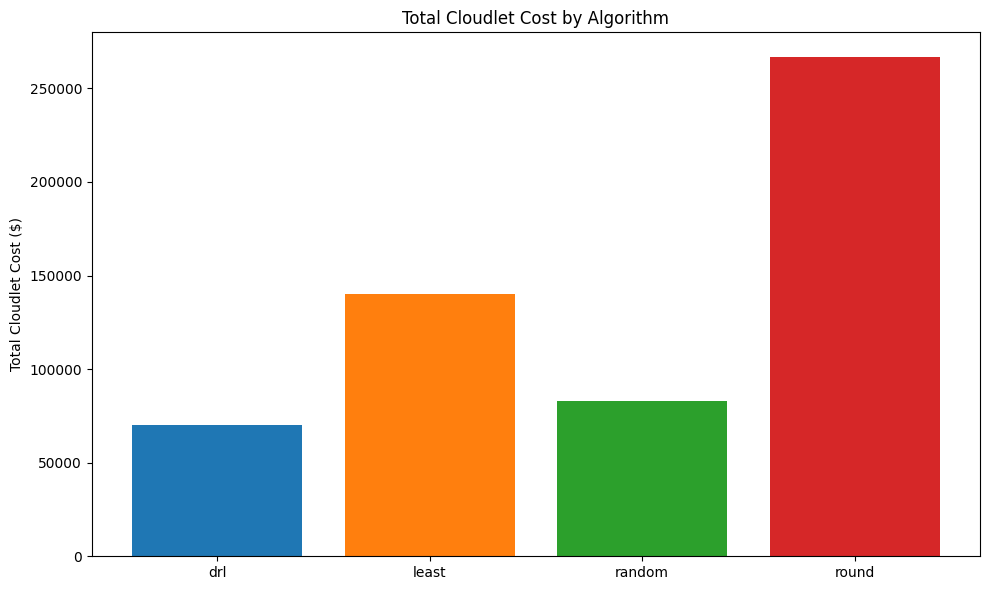

In [4]:
bar_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

# Total Cloudlet Cost plot
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(summary_df['Algorithm'], summary_df['Total Cloudlet Cost ($)'], color=bar_colors)
ax.set_ylabel('Total Cloudlet Cost ($)')
ax.set_title('Total Cloudlet Cost by Algorithm')
plt.tight_layout()
plt.savefig('figs/total_cloudlet_cost.png')
plt.show()

#### Plot 2: Mean Completion Time


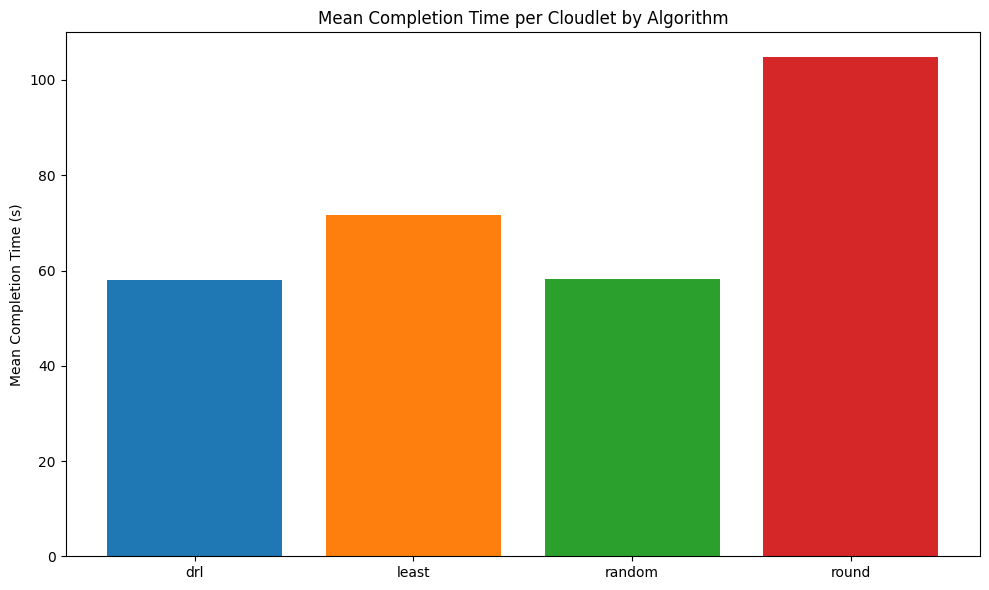

In [5]:
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(summary_df['Algorithm'], summary_df['Mean Completion Time (s)'], color=bar_colors)
ax.set_ylabel('Mean Completion Time (s)')
ax.set_title('Mean Completion Time per Cloudlet by Algorithm')
plt.tight_layout()
plt.savefig('figs/mean_completion_time.png')
plt.show()

#### Plot 3: Mean CPU Utilization


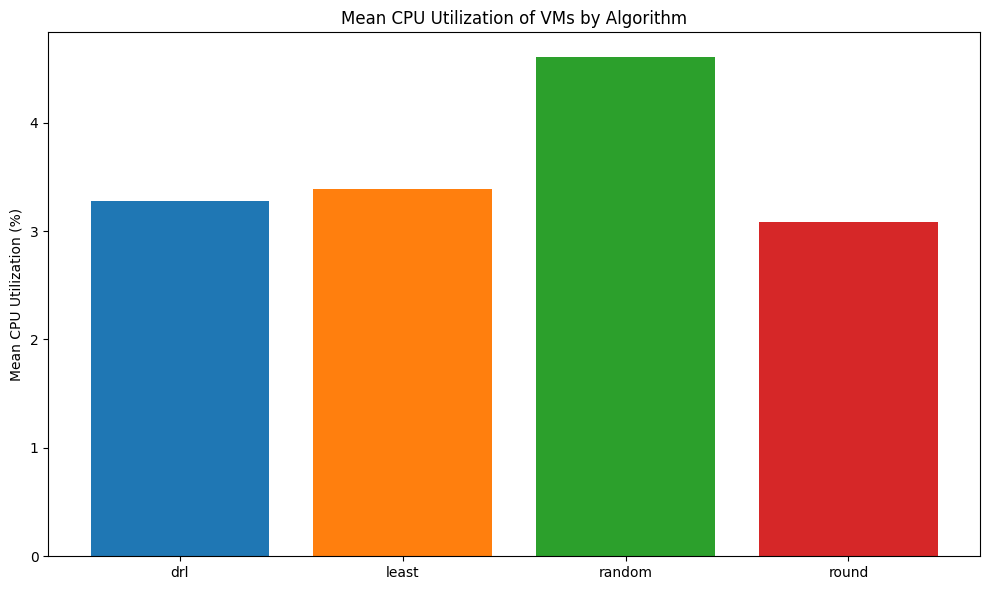

In [6]:
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(summary_df['Algorithm'], summary_df['Mean CPU Utilization (%)'], color=bar_colors)
ax.set_ylabel('Mean CPU Utilization (%)')
ax.set_title('Mean CPU Utilization of VMs by Algorithm')
plt.tight_layout()
plt.savefig('figs/mean_cpu_util.png')
plt.show()

#### Plot 4: Boxplot of Cloudlet Completion Times


C:\Users\Ahmed Khaled\AppData\Local\Temp\ipykernel_25840\962070284.py:10: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.boxplot(data=combined_df, x='Algorithm', y='CompletionTime Seconds', hue='Algorithm', palette=bar_colors, ax=ax, legend=False)


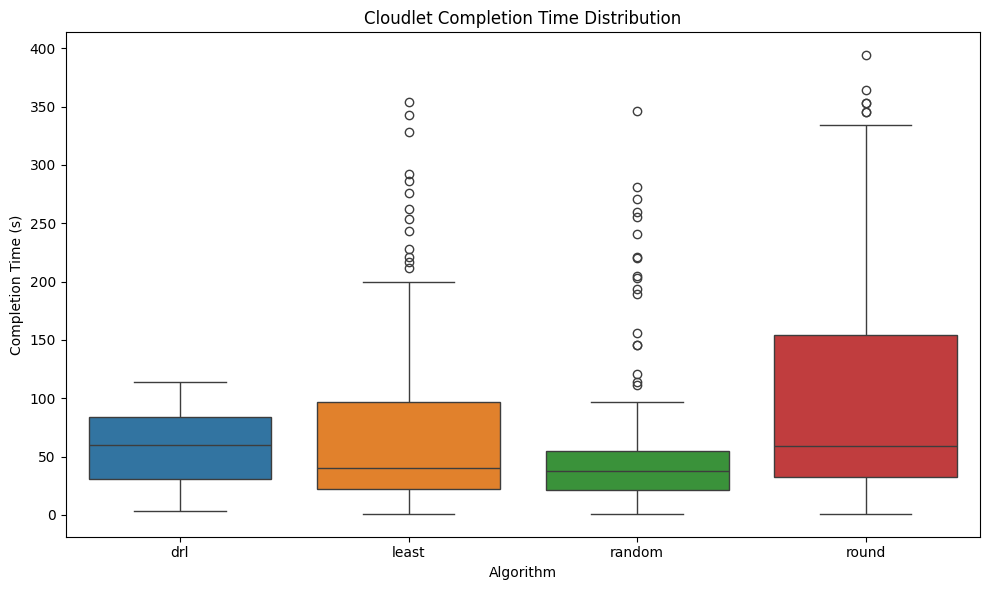

In [7]:
all_completion_times = []
for algo in algorithms:
    cloudlet_df = pd.read_csv(f"data/{algo}_cloudlets.csv")
    cloudlet_df['Algorithm'] = algo
    all_completion_times.append(cloudlet_df[['CompletionTime Seconds', 'Algorithm']])

combined_df = pd.concat(all_completion_times)

fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=combined_df, x='Algorithm', y='CompletionTime Seconds', hue='Algorithm', palette=bar_colors, ax=ax, legend=False)
ax.set_ylabel('Completion Time (s)')
ax.set_title('Cloudlet Completion Time Distribution')
plt.tight_layout()
plt.savefig('figs/completion_time_boxplot.png')
plt.show()

#### Statistical significance tests (pairwise t-tests)


In [8]:
from scipy.stats import ttest_ind
from itertools import combinations

# Load all cloudlet data
cloudlet_data = {}
for algo in algorithms:
    df = pd.read_csv(f"data/{algo}_cloudlets.csv")
    cloudlet_data[algo] = df

# Pairwise t-tests on Completion Time
print("\nPairwise t-tests on Completion Time:")
for (algo1, algo2) in combinations(algorithms, 2):
    time1 = cloudlet_data[algo1]['CompletionTime Seconds']
    time2 = cloudlet_data[algo2]['CompletionTime Seconds']
    t_stat, p_value = ttest_ind(time1, time2, equal_var=False)
    print(f"{algo1} vs {algo2}: p-value = {p_value:.4f}")



Pairwise t-tests on Completion Time:
drl vs least: p-value = 0.0663
drl vs random: p-value = 0.9841
drl vs round: p-value = 0.0000
least vs random: p-value = 0.1378
least vs round: p-value = 0.0013
random vs round: p-value = 0.0000


#### Plot Pareto frontier (cost vs. performance)


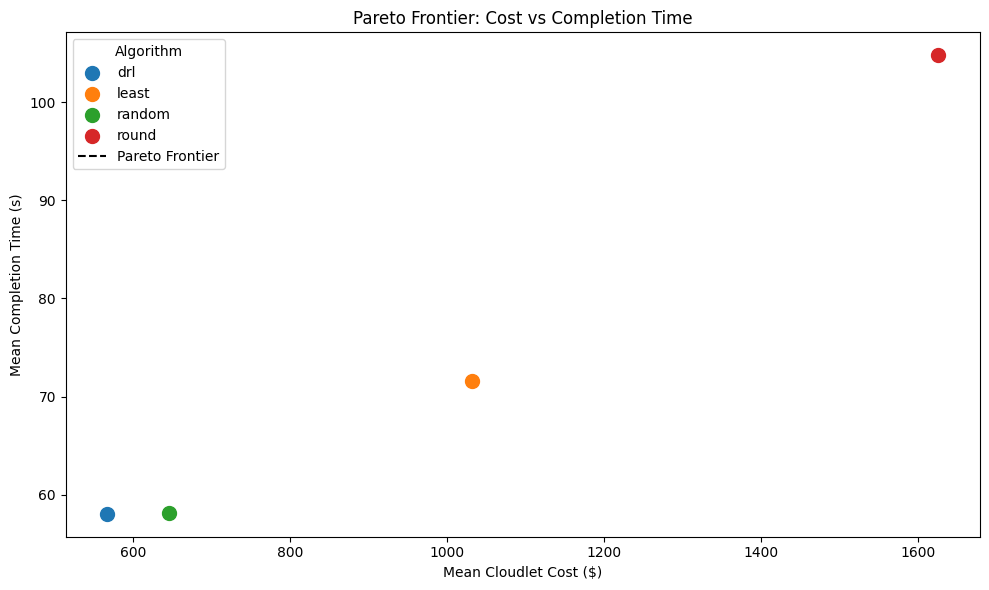

In [9]:
# Sort by cost, find Pareto frontier
costs = summary_df['Mean Cloudlet Cost ($)'].values
times = summary_df['Mean Completion Time (s)'].values

is_pareto = np.ones(costs.shape[0], dtype=bool)
for i, c in enumerate(costs):
    is_pareto[i] = np.all((costs < c) | (times < times[i]) | (i == np.arange(len(costs))))

pareto_df = summary_df[is_pareto]

# Sort Pareto points by cost
pareto_df_sorted = pareto_df.sort_values('Mean Cloudlet Cost ($)')

fig, ax = plt.subplots(figsize=(10,6))
for i, row in summary_df.iterrows():
    ax.scatter(row['Mean Cloudlet Cost ($)'], row['Mean Completion Time (s)'], label=row['Algorithm'], s=100)
ax.plot(pareto_df['Mean Cloudlet Cost ($)'], pareto_df['Mean Completion Time (s)'], 'k--', label='Pareto Frontier')
ax.set_xlabel('Mean Cloudlet Cost ($)')
ax.set_ylabel('Mean Completion Time (s)')
ax.set_title('Pareto Frontier: Cost vs Completion Time')
ax.legend(title='Algorithm')
plt.tight_layout()
plt.savefig('figs/pareto_frontier.png')
plt.show()